In [1]:
# PRE

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# required packages
packages = [
    'numpy',
    'pandas', 
    'matplotlib',
    'scipy',
    'seaborn',
    'pymc',
    'arviz',
    'scikit-learn'
]

print("installing required packages...")
for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"installing {package}...")
        install(package)
        print(f"✓ {package} installed successfully")

print("\nall packages are ready!")

installing required packages...
✓ numpy is already installed
✓ pandas is already installed
✓ matplotlib is already installed
✓ scipy is already installed


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


✓ seaborn is already installed
✓ pymc is already installed
✓ arviz is already installed
installing scikit-learn...
✓ scikit-learn installed successfully

all packages are ready!


Original data shape: (2578, 21)

=== FINAL FEATURES ===
 1. UWI
 2. tbguid
 3. lifetime_start
 4. FAILURETYPE
 5. GrossStrokeLength
 6. Fillage
 7. YesterdaysAverageSPM
 8. bha_configuration
 9. gas_anchor_length
10. MAX_INCLINATION
11. AVG_PRESS_FLOWLINE
12. AVG_PRESSURE_TUBING
13. AVG_PRESSURE_CASING
14. AVG_LIQUID_VOLUME
15. AVG_WATERSG
16. ROUTE
17. FAILED
18. lifetime_duration_days
19. WaterRatio
20. chemgroup1_score
21. chemgroup2_score
✓ Dropped 3 column(s): ['chemgroup1_score', 'chemgroup2_score', 'ROUTE']

Using 18 features from postFS_df.csv after drops
Variables:
  - UWI
  - tbguid
  - lifetime_start
  - FAILURETYPE
  - GrossStrokeLength
  - Fillage
  - YesterdaysAverageSPM
  - bha_configuration
  - gas_anchor_length
  - MAX_INCLINATION
  - AVG_PRESS_FLOWLINE
  - AVG_PRESSURE_TUBING
  - AVG_PRESSURE_CASING
  - AVG_LIQUID_VOLUME
  - AVG_WATERSG
  - FAILED
  - lifetime_duration_days
  - WaterRatio

All numerical variables (13):
   1. GrossStrokeLength
   2. Fillage
   3. Yeste

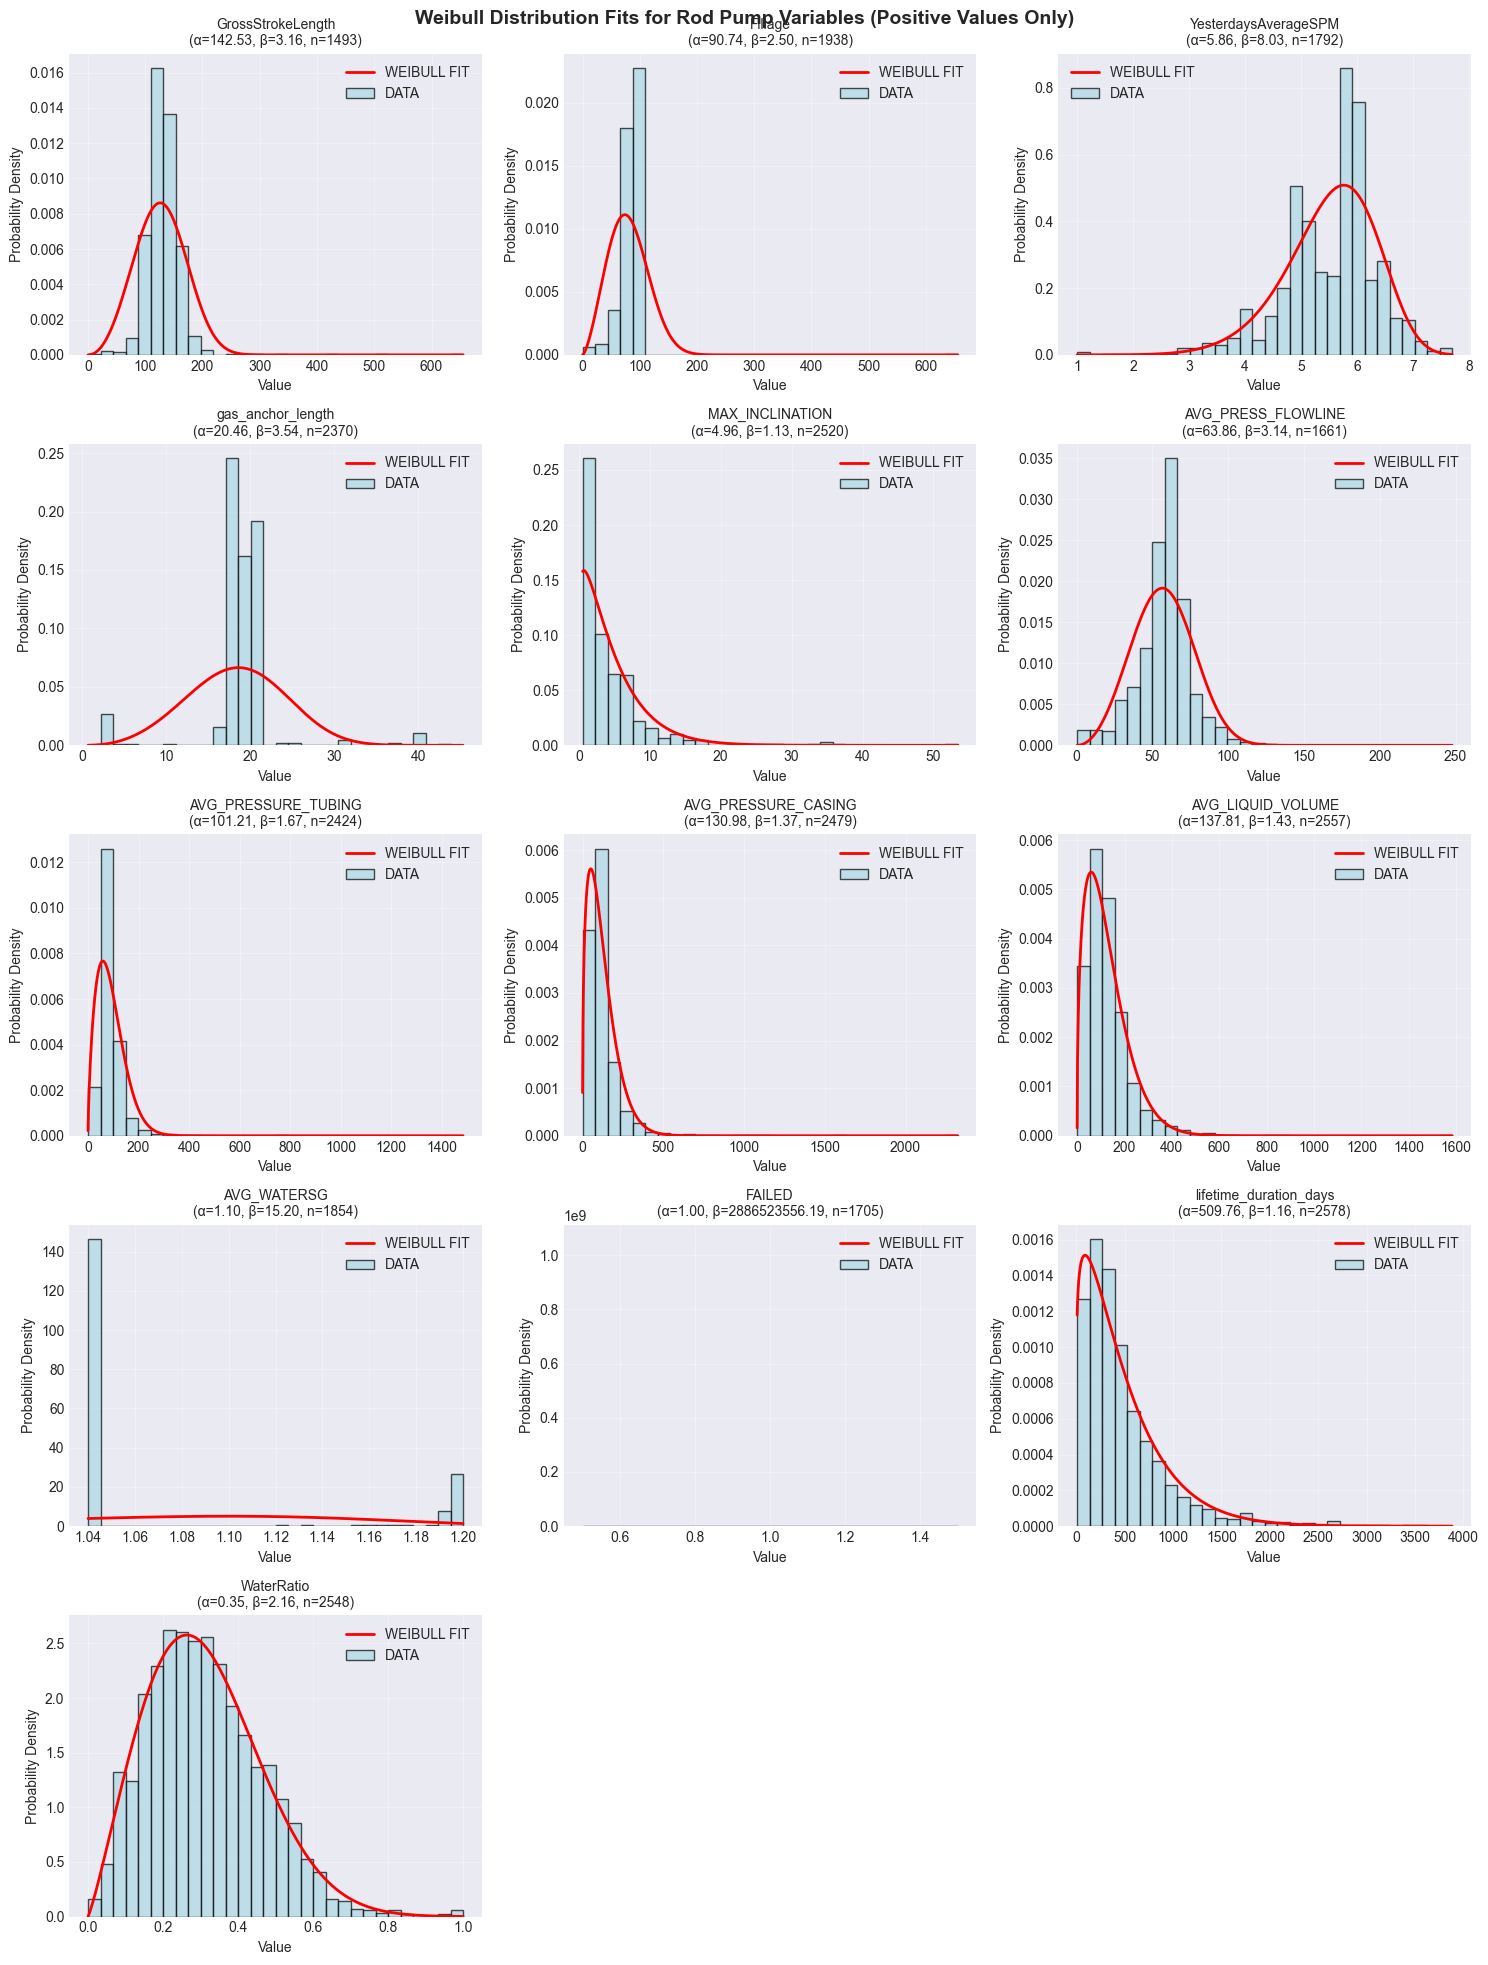


WEIBULL DISTRIBUTION FITTING SUMMARY
Variable                  Scale(α)   Shape(β)   n_used   n_total 
--------------------------------------------------------------------------------
GrossStrokeLength         142.5340   3.1554     1493     1500    
Fillage                   90.7411    2.4957     1938     1984    
YesterdaysAverageSPM      5.8606     8.0317     1792     1825    
gas_anchor_length         20.4620    3.5351     2370     2574    
MAX_INCLINATION           4.9636     1.1266     2520     2529    
AVG_PRESS_FLOWLINE        63.8640    3.1388     1661     1661    
AVG_PRESSURE_TUBING       101.2123   1.6744     2424     2538    
AVG_PRESSURE_CASING       130.9801   1.3742     2479     2544    
AVG_LIQUID_VOLUME         137.8150   1.4290     2557     2578    
AVG_WATERSG               1.1049     15.2008    1854     1854    
FAILED                    1.0000     2886523556.1939 1705     2578    
lifetime_duration_days    509.7647   1.1552     2578     2578    
WaterRatio        

In [2]:
# fit_to_weibull.ipynb
"""
Weibull Distribution Analysis for Rod Pump Failure Data
Python conversion of fit_to_weibull.m
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# post-feature-selection data
df = pd.read_csv('postFS_df.csv')
print(f"Original data shape: {df.shape}")

# final features
print("\n=== FINAL FEATURES ===")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


# dataframe as-is
df_clean = df.copy()
# drop any chemgroup score features (case-insensitive)...
# since values are binary, we can't use weibull. needs to be continuous
# remove columns that contain both 'chemgroup' and 'score' in their name
cols_to_drop = [c for c in df_clean.columns if ('chemgroup' in c.lower() and 'score' in c.lower())] + ['ROUTE'] # and drop route since categorical
if cols_to_drop:
    df_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    print(f"✓ Dropped {len(cols_to_drop)} column(s): {cols_to_drop}")
else:
    print("No columns found to drop.")
print(f"\nUsing {df_clean.shape[1]} features from postFS_df.csv after drops")
print("Variables:")
for col in df_clean.columns:
    print(f"  - {col}")

# ============================================================================
# WEIBULL FITTING FUNCTIONS
# ============================================================================

def fit_weibull_to_variables(data, var_names):
    """
    Fit Weibull distribution to each variable
    """
    n_samples, n_vars = data.shape
    weibull_params = []
    
    # subplot layout
    n_cols = 3
    n_rows = int(np.ceil(n_vars / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_vars > 1 else [axes]
    
    for i, (var_name, ax) in enumerate(zip(var_names, axes)):
        if i >= len(axes):
            break
            
        current_data = data[:, i]
        
        # remove missing values and ensure positive values for weibull
        current_data = current_data[~np.isnan(current_data) & ~np.isinf(current_data) & (current_data > 0)]
        
        if len(current_data) < 5:
            ax.text(0.5, 0.5, f'Cannot fit\n{var_name}\n(n={len(current_data)})',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(var_name, fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        try:
            # fit weibull distribution using scipy
            params = stats.weibull_min.fit(current_data, floc=0)
            shape, loc, scale = params
            a, b = scale, shape
            
            # histogram with fitted weibull PDF
            ax.hist(current_data, bins=30, density=True, alpha=0.7,
                   color='lightblue', edgecolor='black')
            
            # PDF for weibull distribution
            x = np.linspace(current_data.min(), current_data.max(), 1000)
            y = stats.weibull_min.pdf(x, b, loc=0, scale=a)
            ax.plot(x, y, 'r-', linewidth=2)
            
            ax.set_title(f'{var_name}\n(α={a:.2f}, β={b:.2f}, n={len(current_data)})', 
                        fontsize=10)
            ax.set_xlabel('Value')
            ax.set_ylabel('Probability Density')
            ax.legend(['WEIBULL FIT', 'DATA'], loc='best')
            ax.grid(True, alpha=0.3)
            
            # store results
            weibull_params.append({
                'variable': var_name,
                'scale': a,
                'shape': b,
                'n_used': len(current_data),
                'original_n': len(data[:, i][~np.isnan(data[:, i]) & ~np.isinf(data[:, i])])
            })
            
        except Exception as e:
            print(f"Error fitting Weibull to {var_name}: {e}")
            ax.text(0.5, 0.5, f'Cannot fit\n{var_name}',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(var_name, fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Weibull Distribution Fits for Rod Pump Variables (Positive Values Only)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('weibull_fits.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return weibull_params

def display_weibull_summary(params):
    """
    Display summary of Weibull parameters
    """
    print("\n" + "="*80)
    print("WEIBULL DISTRIBUTION FITTING SUMMARY")
    print("="*80)
    
    print(f"{'Variable':<25} {'Scale(α)':<10} {'Shape(β)':<10} {'n_used':<8} {'n_total':<8}")
    print("-"*80)
    
    for param in params:
        print(f"{param['variable']:<25} {param['scale']:<10.4f} {param['shape']:<10.4f} "
              f"{param['n_used']:<8} {param['original_n']:<8}")
    
    print("\n" + "="*80)
    print("WEIBULL SHAPE PARAMETER INTERPRETATION")
    print("="*80)
    print("β < 1: Decreasing failure rate (early failures / infant mortality)")
    print("β = 1: Constant failure rate (exponential distribution)")
    print("β > 1: Increasing failure rate (wear-out failures)")
    
    # identify variables that couldn't be fit completely
    print("\n" + "="*80)
    print("VARIABLES WITH ZEROS/NEGATIVES (Cannot fit Weibull)")
    print("="*80)
    
    for param in params:
        if param['n_used'] < param['original_n']:
            print(f"{param['variable']}: used {param['n_used']}/{param['original_n']} observations "
                  "(excluded zeros/negatives)")

# ============================================================================
# MAIN WEIBULL ANALYSIS
# ============================================================================

# extract numerical data from all features
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nAll numerical variables ({len(numeric_cols)}):")
for i, col in enumerate(numeric_cols, 1):
    print(f"  {i:2d}. {col}")

# check each variable for data quality before weibull fitting
print("\n=== Data Quality Check for Weibull Fitting ===")
print("Weibull distribution requires strictly positive values (> 0)")
print("-"*60)

for col in numeric_cols:
    data = df_clean[col].dropna()
    positive_data = data[data > 0]
    zero_count = (data == 0).sum()
    negative_count = (data < 0).sum()
    
    can_fit_weibull = len(positive_data) >= 5
    
    status = "✓ CAN FIT" if can_fit_weibull else "✗ CANNOT FIT"
    
    print(f"{col:25s}: {status}")
    print(f"  {' ':<25}  Total={len(data):4d}, Positive={len(positive_data):4d} "
          f"({len(positive_data)/len(data)*100:.1f}%), "
          f"Zeros={zero_count:3d}, Negatives={negative_count:3d}")
    print(f"  {' ':<25}  Range=[{data.min():8.4f}, {data.max():8.4f}]")

# EXCLUDE variables that cannot fit weibull (zeros/negatives, not enough positive data)
variables_to_exclude = []
for col in numeric_cols:
    data = df_clean[col].dropna()
    positive_data = data[data > 0]
    if len(positive_data) < 5:
        variables_to_exclude.append(col)

# remove excluded variables from weibull analysis
numeric_cols_weibull = [col for col in numeric_cols if col not in variables_to_exclude]

print(f"\n=== Variables for Weibull Fitting ===")
print(f"Included ({len(numeric_cols_weibull)}):")
for i, col in enumerate(numeric_cols_weibull, 1):
    print(f"  {i:2d}. {col}")

if variables_to_exclude:
    print(f"\nExcluded ({len(variables_to_exclude)} - cannot fit Weibull):")
    for i, col in enumerate(variables_to_exclude, 1):
        print(f"  {i:2d}. {col}")

# extract numerical data for weibull fitting
numeric_data = df_clean[numeric_cols_weibull].values

# fit weibull to each variable
weibull_params = fit_weibull_to_variables(numeric_data, numeric_cols_weibull)

# display summary
if weibull_params:
    display_weibull_summary(weibull_params)
else:
    print("\nNo successful Weibull fits - all variables contain zeros/negatives")

# ============================================================================
# ENHANCED WEIBULL ANALYSIS FOR LIFETIME DATA
# ============================================================================

print("\n" + "="*80)
print("ENHANCED WEIBULL ANALYSIS FOR LIFETIME DATA")
print("="*80)

# check if we have lifetime data
if 'lifetime_duration_days' in df.columns and 'FAILED' in df.columns:
    # separate failed and censored data
    failed_data = df[df['FAILED'] == 1]['lifetime_duration_days'].dropna()
    censored_data = df[df['FAILED'] == 0]['lifetime_duration_days'].dropna()
    
    print(f"Failed pumps: {len(failed_data)}")
    print(f"Censored pumps: {len(censored_data)}")
    
    if len(failed_data) >= 10:
        # fit weibull to failure times
        try:
            params = stats.weibull_min.fit(failed_data, floc=0)
            shape, loc, scale = params
            
            # calculate reliability metrics
            def weibull_survival(t, shape, scale):
                return np.exp(-(t/scale)**shape)
            
            def weibull_hazard(t, shape, scale):
                return (shape/scale) * (t/scale)**(shape-1)
            
            # B10 life (time when 10% have failed)
            b10_life = scale * (-np.log(0.9))**(1/shape)
            
            # B50 life (median life)
            b50_life = scale * (np.log(2))**(1/shape)
            
            # mean time to failure
            mttf = scale * stats.gamma(1 + 1/shape)
            
            print(f"\nWeibull Fit for Pump Lifetime:")
            print(f"  Shape (β): {shape:.3f} - {('Wear-out failures' if shape > 1 else 'Early failures' if shape < 1 else 'Random failures')}")
            print(f"  Scale (α): {scale:.1f} days")
            print(f"  B10 Life: {b10_life:.1f} days (time when 10% fail)")
            print(f"  B50 Life: {b50_life:.1f} days (median life)")
            print(f"  MTTF: {mttf:.1f} days (mean time to failure)")
            
            # plot survival and hazard functions
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # survival function
            t_range = np.linspace(0, failed_data.max() * 1.2, 1000)
            survival_prob = weibull_survival(t_range, shape, scale)
            
            ax1.plot(t_range, survival_prob, 'b-', linewidth=2)
            ax1.fill_between(t_range, 0, survival_prob, alpha=0.3)
            ax1.axvline(x=b10_life, color='r', linestyle='--', label=f'B10 Life: {b10_life:.0f} days')
            ax1.axvline(x=b50_life, color='g', linestyle='--', label=f'B50 Life: {b50_life:.0f} days')
            ax1.set_xlabel('Time (days)')
            ax1.set_ylabel('Survival Probability')
            ax1.set_title('Weibull Survival Function')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # hazard function
            hazard_rate = weibull_hazard(t_range, shape, scale)
            ax2.plot(t_range, hazard_rate, 'r-', linewidth=2)
            ax2.set_xlabel('Time (days)')
            ax2.set_ylabel('Hazard Rate')
            ax2.set_title('Weibull Hazard Function')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('lifetime_weibull_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # maintenance interval recommendations
            print(f"\nMaintenance Recommendations:")
            print(f"  First inspection: {b10_life * 0.3:.0f} days (30% of B10 life)")
            print(f"  Preventive maintenance: {b10_life * 0.7:.0f} days (70% of B10 life)")
            print(f"  Replacement planning: {b10_life:.0f} days (B10 life)")
            
        except Exception as e:
            print(f"Error fitting Weibull to lifetime data: {e}")
    else:
        print("Insufficient failure data for Weibull analysis")
else:
    print("Lifetime data not available for enhanced analysis")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# save weibull parameters to CSV
if weibull_params:
    weibull_df = pd.DataFrame(weibull_params)
    weibull_df.to_csv('weibull_parameters.csv', index=False)
    print("✓ Weibull parameters saved to 'weibull_parameters.csv'")

# save summary statistics for all numerical variables
summary_stats = df_clean[numeric_cols].describe()
summary_stats.to_csv('summary_statistics_all_variables.csv')
print("✓ Summary statistics for all variables saved to 'summary_statistics_all_variables.csv'")

# save statistics for weibull-fitted variables
if numeric_cols_weibull:
    weibull_stats = df_clean[numeric_cols_weibull].describe()
    weibull_stats.to_csv('summary_statistics_weibull_variables.csv')
    print("✓ Summary statistics for Weibull-fitted variables saved to 'summary_statistics_weibull_variables.csv'")

print("\nANALYSIS COMPLETE")
print("Generated files:")
print("1. weibull_fits.png - Weibull distribution fits for all variables")
print("2. lifetime_weibull_analysis.png - Survival and hazard functions")
print("3. weibull_parameters.csv - Weibull parameters for fitted variables")
print("4. summary_statistics_all_variables.csv - Statistics for all variables")
print("5. summary_statistics_weibull_variables.csv - Statistics for Weibull-fitted variables")

WEIBULL AFT MODELING

--- Preparing Data for AFT Modeling ---
Time scaled to years: range = 0.02 to 10.64
Detected 16 covariates: ['UWI', 'tbguid', 'lifetime_start', 'FAILURETYPE', 'GrossStrokeLength', 'Fillage', 'YesterdaysAverageSPM', 'bha_configuration', 'gas_anchor_length', 'MAX_INCLINATION', 'AVG_PRESS_FLOWLINE', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING', 'AVG_LIQUID_VOLUME', 'AVG_WATERSG', 'WaterRatio']

Numeric covariates (11): ['GrossStrokeLength', 'Fillage', 'YesterdaysAverageSPM', 'gas_anchor_length', 'MAX_INCLINATION', 'AVG_PRESS_FLOWLINE', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING', 'AVG_LIQUID_VOLUME', 'AVG_WATERSG', 'WaterRatio']
Non-numeric covariates (5): ['UWI', 'tbguid', 'lifetime_start', 'FAILURETYPE', 'bha_configuration']
Columns with missing values: ['GrossStrokeLength', 'Fillage', 'YesterdaysAverageSPM', 'gas_anchor_length', 'MAX_INCLINATION', 'AVG_PRESS_FLOWLINE', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING', 'AVG_WATERSG', 'WaterRatio']
Applying KNN imputat

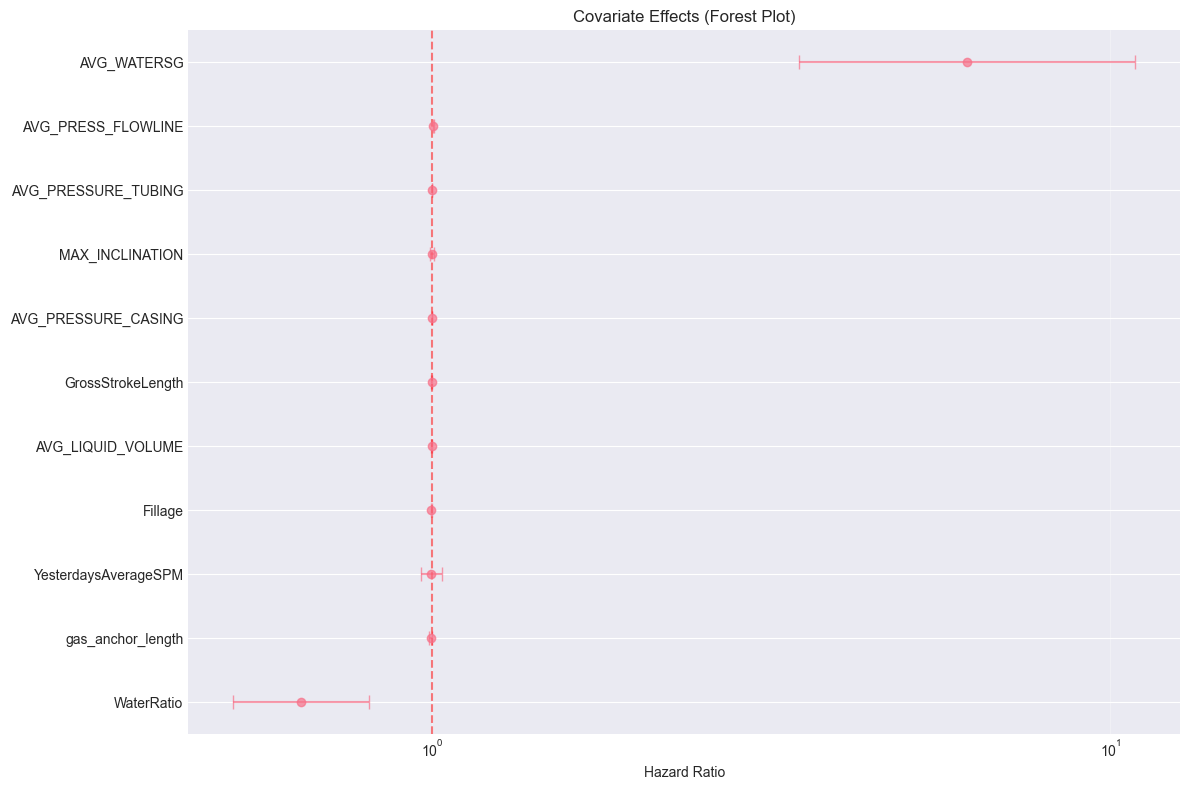


--- Generating Predictions ---
High-risk pumps: 258 (10.0%)
Mean absolute error (failures): 279.8 days

--- Saving Results ---
✓ Model summary saved
✓ Predictions saved
✓ Effects analysis saved
Results saved to 'weibull_aft_results/'

ANALYSIS COMPLETE

Top findings:
1. Most hazardous: WaterRatio (HR=0.642)
2. Most protective: AVG_WATERSG (HR=6.153)

Model performance: C-index = 0.6021
High-risk pumps identified: 258
End time: 2025-12-03 11:47:46.187882

--- Model Parameters Debug ---
Model params shape: (13,)
Model params index: Index(['lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_',
       'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_',
       'rho_'],
      dtype='object', name='param')
Looking for lambda parameters...
Found lambda parameters: ['lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_', 'lambda_']
Number of covariates used: 11
Covariates: ['GrossStrokeLength', 'Fillage',

In [10]:
"""
Weibull Accelerated Failure Time (AFT) Modeling
Runs on the preprocessed df_clean from fit_to_weibull.ipynb
"""
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
# break

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import WeibullAFTFitter
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

print("="*80)
print("WEIBULL AFT MODELING")
print("="*80)

# ============================================================================
# configuration (uses existing df_clean from fit_to_weibull.ipynb)
# ============================================================================

time_column = "lifetime_duration_days"
event_column = "FAILED"
output_dir = "weibull_aft_results"

# ============================================================================
# data preparation (uses df_clean from previous cell)
# ============================================================================

print("\n--- Preparing Data for AFT Modeling ---")

# preprocessed df_clean from fit_to_weibull
df_aft = df_clean.copy()

# time to years to prevent convergence issues
df_aft[time_column] = df_aft[time_column] / 365.25
print(f"Time scaled to years: range = {df_aft[time_column].min():.2f} to {df_aft[time_column].max():.2f}")

# detect covariates (excluding time and event columns)
covariates = [col for col in df_aft.columns if col not in [time_column, event_column]]
print(f"Detected {len(covariates)} covariates: {covariates}")

# separate numeric and non-numeric covariates
numeric_covariates = [c for c in covariates if np.issubdtype(df_aft[c].dtype, np.number)]
non_numeric = [c for c in covariates if not np.issubdtype(df_aft[c].dtype, np.number)]

print(f"\nNumeric covariates ({len(numeric_covariates)}): {numeric_covariates}")
print(f"Non-numeric covariates ({len(non_numeric)}): {non_numeric}")

# use only numeric covariates for modeling
covariates = numeric_covariates.copy()

# missing values - using KNN imputation for better results
missing_cols = [col for col in covariates if df_aft[col].isnull().any()]
if missing_cols:
    print(f"Columns with missing values: {missing_cols}")
    
    # if we have enough data for KNN
    if len(df_aft) > 10 and len(missing_cols) > 0:  # minimum samples
        try:
            from sklearn.impute import KNNImputer
            from sklearn.preprocessing import StandardScaler
            
            print(f"Applying KNN imputation to {len(missing_cols)} columns...")
            
            # features before KNN imputation
            scaler = StandardScaler()
            
            # indices for rows that will be used for fitting (non-missing)
            fit_mask = ~df_aft[missing_cols].isnull().any(axis=1)
            
            if fit_mask.sum() > 5:  # Enough samples to fit scaler
                # fit scaler on non-missing data only
                scaler.fit(df_aft.loc[fit_mask, missing_cols])
                
                # transform all data
                scaled_data = scaler.transform(df_aft[missing_cols])
                
                # make and fit KNN imputer
                imputer = KNNImputer(
                    n_neighbors=min(5, fit_mask.sum() - 1),  # modular
                    weights='distance'
                )
                
                # fit on non-missing data only
                imputer.fit(scaled_data[fit_mask])
                
                # impute all data
                imputed_scaled = imputer.transform(scaled_data)
                
                # inverse transform back to original scale
                imputed_data = scaler.inverse_transform(imputed_scaled)
                
                # dataframe
                df_aft[missing_cols] = imputed_data
                print(f"✓ Applied KNN imputation to {len(missing_cols)} columns")
            else:
                raise ValueError("Not enough complete cases for KNN imputation")
                
        except Exception as e:
            print(f"KNN imputation failed: {e}")
            print("Falling back to median imputation...")
            # fallback to median imputation
            for col in missing_cols:
                df_aft[col] = df_aft[col].fillna(df_aft[col].median())
                print(f"  Filled missing values in {col} (median)")
    else:
        # not enough data for KNN, use median
        print("Not enough data for KNN, using median imputation")
        for col in missing_cols:
            df_aft[col] = df_aft[col].fillna(df_aft[col].median())
            print(f"  Filled missing values in {col} (median)")
else:
    print("No missing values found in covariates")

# ensure time column is positive
if (df_aft[time_column] <= 0).any():
    print(f"WARNING: Removing {(df_aft[time_column] <= 0).sum()} non-positive time values")
    df_aft = df_aft[df_aft[time_column] > 0].copy()

print(f"Final dataset shape: {df_aft.shape}")
print(f"Events: {df_aft[event_column].sum()} failures, {len(df_aft) - df_aft[event_column].sum()} censored")

# ============================================================================
# model fitting
# ============================================================================

print("\n--- Fitting Weibull AFT Model ---")

# modeling dataset
df_model = df_aft[covariates + [time_column, event_column]].copy()

# initialize model with strong regularization (prevents convergence errors)
aft = WeibullAFTFitter(
    penalizer=0.5,  # Strong regularization
    fit_intercept=True,
    model_ancillary=False
)

# clean column names first (remove special characters, spaces)
print("\n--- Checking and cleaning column names ---")
clean_covariates = []
for cov in covariates:
    # check if column name contains spaces or special characters
    if any(c in cov for c in [' ', '-', '(', ')', '[', ']', '{', '}', '.', ',']):
        clean_name = cov.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '')
        clean_name = clean_name.replace('[', '').replace(']', '').replace('{', '').replace('}', '')
        clean_name = clean_name.replace('.', '_').replace(',', '_')
        print(f"  Cleaning: '{cov}' -> '{clean_name}'")
        df_model = df_model.rename(columns={cov: clean_name})
        clean_covariates.append(clean_name)
    else:
        clean_covariates.append(cov)

covariates = clean_covariates.copy()
print(f"Using cleaned covariates: {covariates}")

# now fit the model with Q() wrapper for column names
try:    
    # set robust optimizer 
    aft._scipy_fit_method = "SLSQP"
    
    # formula with Q() wrapper for safety
    formula_parts = []
    for cov in covariates:
        # wrap each covariate in Q() to handle special characters
        formula_parts.append(f"Q('{cov}')")
    
    formula = " + ".join(formula_parts)
    print(f"Using formula: {formula}")
    
    aft.fit(
        df_model,
        duration_col=time_column,
        event_col=event_column,
        formula=formula,
        fit_options={"maxiter": 1000}
    )

    c_index = aft.score(df_model, scoring_method="concordance_index")
    print(f"✓ Model fitting successful!")
    print(f"  C-index: {c_index:.4f}") 
    
except Exception as e:
    print(f"✗ Model fitting failed: {e}")
    print("  Try increasing penalizer or reducing covariates")
    raise

# ============================================================================
# results analysis
# ============================================================================

print("\n--- Analyzing Results ---")

params = aft.params_
ci = aft.confidence_intervals_
summary = aft.summary

# debug - show the full structure
print("\n--- Model Parameters Debug ---")
print(f"Model params type: {type(params)}")
print(f"Model params index type: {type(params.index)}")
print(f"Model params index levels: {params.index.names if hasattr(params.index, 'names') else 'No MultiIndex'}")
print(f"Model params:\n{params}")

print(f"\nConfidence intervals columns: {ci.columns.tolist()}")
print(f"Confidence intervals head:\n{ci.head()}")

print(f"\nSummary columns: {summary.columns.tolist()}")
print(f"Summary head:\n{summary.head()}")

# handle MultiIndex properly
if isinstance(params.index, pd.MultiIndex):
    print("\nMultiIndex detected, extracting both levels...")
    # get all lambda parameters (excluding intercept and rho)
    lambda_mask = params.index.get_level_values(0) == 'lambda_'
    intercept_mask = params.index.get_level_values(1) != 'Intercept'
    
    # filter for lambda parameters that are not intercept
    lambda_params = params[lambda_mask & intercept_mask]
    print(f"\nFound {len(lambda_params)} lambda parameters (excluding intercept):")
    
    # extract effects
    effects = []
    for idx in lambda_params.index:
        param_type = idx[0]  # 'lambda_'
        cov_name = idx[1]    # e.g., "Q('GrossStrokeLength')"
        
        # clean covariate name from Q() wrapper
        if cov_name.startswith("Q('") and cov_name.endswith("')"):
            clean_cov = cov_name[3:-2]  # remove Q(' and ')
        else:
            clean_cov = cov_name
        
        coef = params.loc[idx]
        exp_coef = np.exp(coef)
        
        # get p-value from summary
        if idx in summary.index:
            # check what the p-value column is actually called
            p_col = 'p' if 'p' in summary.columns else summary.columns[4]  # usually 5th column is p-value
            p_val = summary.loc[idx, p_col]
        else:
            p_val = np.nan
        
        # get confidence intervals - check column names
        if idx in ci.index:
            # check what the confidence interval columns are called
            if len(ci.columns) >= 2:
                ci_lower = ci.loc[idx, ci.columns[0]]  # first column is lower
                ci_upper = ci.loc[idx, ci.columns[1]]  # second column is upper
            else:
                ci_lower = np.nan
                ci_upper = np.nan
        else:
            ci_lower = np.nan
            ci_upper = np.nan
        
        effects.append({
            'covariate': clean_cov,
            'parameter_name': f"{param_type}{cov_name}",
            'coef': float(coef),
            'hazard_ratio': float(exp_coef),
            'p_value': float(p_val) if not np.isnan(p_val) else np.nan,
            'significant': p_val < 0.05 if not np.isnan(p_val) else False,
            'ci_lower': float(np.exp(ci_lower)) if not np.isnan(ci_lower) else np.nan,
            'ci_upper': float(np.exp(ci_upper)) if not np.isnan(ci_upper) else np.nan
        })
        
        print(f"  {clean_cov}: coef={coef:.6f}, HR={exp_coef:.3f}, p={p_val:.4f}")
        
else:
    # fallback
    params_index = params.index.get_level_values(0) if isinstance(params.index, pd.MultiIndex) else params.index
    ci_index = ci.index.get_level_values(0) if isinstance(ci.index, pd.MultiIndex) else ci.index
    summary_index = summary.index.get_level_values(0) if isinstance(summary.index, pd.MultiIndex) else summary.index
    
    # extract effects
    effects = []
    for cov in covariates:
        lambda_idx = f"lambda_Q('{cov}')"
        lambda_idx2 = f"lambda_{cov}"
        
        if lambda_idx in params_index:
            idx_to_use = lambda_idx
        elif lambda_idx2 in params_index:
            idx_to_use = lambda_idx2
        else:
            print(f"  Warning: Could not find parameter for covariate '{cov}'")
            continue
        
        idx_pos = list(params_index).index(idx_to_use)
        coef = params.iloc[idx_pos, 0] if isinstance(params, pd.DataFrame) else params.iloc[idx_pos]
        exp_coef = np.exp(coef)
        
        if idx_to_use in summary_index:
            summary_pos = list(summary_index).index(idx_to_use)
            p_val = summary.iloc[summary_pos, summary.columns.get_loc('p')] if isinstance(summary, pd.DataFrame) else summary.loc[idx_to_use, 'p']
        else:
            p_val = np.nan
        
        if idx_to_use in ci_index:
            ci_pos = list(ci_index).index(idx_to_use)
            ci_lower = ci.iloc[ci_pos, ci.columns.get_loc(ci.columns[0])] if isinstance(ci, pd.DataFrame) else ci.loc[idx_to_use, ci.columns[0]]
            ci_upper = ci.iloc[ci_pos, ci.columns.get_loc(ci.columns[1])] if isinstance(ci, pd.DataFrame) else ci.loc[idx_to_use, ci.columns[1]]
        else:
            ci_lower = np.nan
            ci_upper = np.nan
        
        effects.append({
            'covariate': cov,
            'parameter_name': idx_to_use,
            'coef': float(coef),
            'hazard_ratio': float(exp_coef),
            'p_value': float(p_val) if not np.isnan(p_val) else np.nan,
            'significant': p_val < 0.05 if not np.isnan(p_val) else False,
            'ci_lower': float(np.exp(ci_lower)) if not np.isnan(ci_lower) else np.nan,
            'ci_upper': float(np.exp(ci_upper)) if not np.isnan(ci_upper) else np.nan
        })

# sort by absolute coefficient magnitude
if effects:
    effects.sort(key=lambda x: abs(x['coef']), reverse=True)
    
    # display results
    print("\n" + "="*80)
    print("SCALE PARAMETER EFFECTS (lambda):")
    print(f"{'covariate':<25} {'coef':>8} {'HR':>8} {'CI(95%)':>20} {'p':>8}")
    print("-" * 75)
    
    for effect in effects:
        sig = "***" if effect['significant'] else ""
        ci_str = f"[{effect['ci_lower']:.2f}-{effect['ci_upper']:.2f}]" if not np.isnan(effect['ci_lower']) else "[NA]"
        p_str = f"{effect['p_value']:.4f}" if not np.isnan(effect['p_value']) else "NA"
        print(f"{effect['covariate']:<25} {effect['coef']:>8.4f} "
              f"{effect['hazard_ratio']:>8.3f} {ci_str:>20} {p_str:>8} {sig}")
else:
    print("\nNo effects found!")

# shape parameter interpretation - FIXED VERSION
rho_found = False
rho_value = None

if isinstance(params.index, pd.MultiIndex):
    # look for rho in MultiIndex
    rho_mask = params.index.get_level_values(0) == 'rho_'
    if rho_mask.any():
        rho_value = float(params[rho_mask].iloc[0])  # get the first rho value
        rho_found = True
else:
    # old method for non-MultiIndex
    params_index = params.index.get_level_values(0) if isinstance(params.index, pd.MultiIndex) else params.index
    for idx in params_index:
        if isinstance(idx, str) and idx.startswith('rho_'):
            idx_pos = list(params_index).index(idx)
            rho_value = float(params.iloc[idx_pos, 0] if isinstance(params, pd.DataFrame) else params.iloc[idx_pos])
            rho_found = True
            break

if rho_found and rho_value is not None:
    print(f"\nSHAPE PARAMETER (rho): {rho_value:.3f}")
    if rho_value > 1:
        print("  → Wear-out failures dominate (hazard increases over time)")
    elif rho_value < 1:
        print("  → Infant mortality failures (hazard decreases over time)")
    else:
        print("  → Constant hazard (random failures)")
else:
    print("\nSHAPE PARAMETER (rho): Not found or not modeled")

# ============================================================================
# visualization
# ============================================================================

print("\n--- Creating Visualizations ---")

os.makedirs(output_dir, exist_ok=True)

if effects:
    # forest plot
    plt.figure(figsize=(12, 8))
    effects_df = pd.DataFrame(effects)
    
    # filter out rows with missing CI for plotting
    plot_effects = effects_df[~effects_df['ci_lower'].isna() & ~effects_df['ci_upper'].isna()].copy()
    
    if not plot_effects.empty:
        plot_effects = plot_effects.sort_values('hazard_ratio')
        y_pos = np.arange(len(plot_effects))
        
        plt.errorbar(plot_effects['hazard_ratio'], y_pos,
                    xerr=[plot_effects['hazard_ratio'] - plot_effects['ci_lower'],
                          plot_effects['ci_upper'] - plot_effects['hazard_ratio']],
                    fmt='o', capsize=5, alpha=0.7)
        
        plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)
        plt.yticks(y_pos, plot_effects['covariate'])
        plt.xlabel('Hazard Ratio')
        plt.title('Covariate Effects (Forest Plot)')
        plt.xscale('log')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'hazard_ratios.png'), dpi=300)
        plt.show()
    else:
        print("  No valid confidence intervals for forest plot")
else:
    print("  No effects to visualize")

# ============================================================================
# predictions
# ============================================================================

print("\n--- Generating Predictions ---")

# predict median survival for all pumps
try:
    pred_median = aft.predict_median(df_model)
    
    predictions = pd.DataFrame({
        'actual_time_days': df_model[time_column] * 365.25,  # Convert back to days
        'event': df_model[event_column],
        'predicted_median_days': pred_median * 365.25,  # Convert back to days
        'risk_score': 1 / pred_median
    })
    
    # identify high-risk pumps (top 10%)
    high_risk_threshold = predictions['risk_score'].quantile(0.9)
    high_risk = predictions[predictions['risk_score'] > high_risk_threshold]
    
    print(f"High-risk pumps: {len(high_risk)} ({len(high_risk)/len(predictions)*100:.1f}%)")
    
    # prediction accuracy for failures
    failures = predictions[predictions['event'] == 1]
    if len(failures) > 0:
        error = failures['predicted_median_days'] - failures['actual_time_days']
        mae = np.abs(error).mean()
        print(f"Mean absolute error (failures): {mae:.1f} days")
        
except Exception as e:
    print(f"Warning: Could not generate predictions - {e}")
    predictions = pd.DataFrame()

# ============================================================================
# save results
# ============================================================================

print("\n--- Saving Results ---")

# save model summary
try:
    aft.summary.to_csv(os.path.join(output_dir, 'model_summary.csv'))
    print("✓ Model summary saved")
except Exception as e:
    print(f"✗ Could not save model summary: {e}")

# save predictions
if not predictions.empty:
    predictions.to_csv(os.path.join(output_dir, 'predictions.csv'), index=False)
    print("✓ Predictions saved")
else:
    print("✗ No predictions to save")

# save effects analysis
if effects:
    pd.DataFrame(effects).to_csv(os.path.join(output_dir, 'effects.csv'), index=False)
    print("✓ Effects analysis saved")
else:
    print("✗ No effects to save")

print(f"Results saved to '{output_dir}/'")

# ============================================================================
# final summary
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

if effects:
    # filter out effects with invalid hazard ratios
    valid_effects = [e for e in effects if not np.isnan(e['hazard_ratio'])]
    
    if valid_effects:
        top_hazard = min(valid_effects, key=lambda x: x['hazard_ratio'])
        top_protective = max(valid_effects, key=lambda x: x['hazard_ratio'])
        
        print(f"\nTop findings:")
        print(f"1. Most hazardous: {top_hazard['covariate']} "
              f"(HR={top_hazard['hazard_ratio']:.3f})")
        print(f"2. Most protective: {top_protective['covariate']} "
              f"(HR={top_protective['hazard_ratio']:.3f})")

print(f"\nModel performance: C-index = {c_index:.4f}")
if not predictions.empty:
    print(f"High-risk pumps identified: {len(high_risk)}")
print(f"End time: {datetime.now()}")

# debug
print("\n--- Model Parameters Debug ---")
print(f"Model params shape: {params.shape}")
print(f"Model params index: {params_index[:20]}")  # show first 20
print(f"Looking for lambda parameters...")
lambda_params = [idx for idx in params_index if isinstance(idx, str) and idx.startswith('lambda_')]
print(f"Found lambda parameters: {lambda_params}")
print(f"Number of covariates used: {len(covariates)}")
print(f"Covariates: {covariates}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class PhysicsBasedValidator:
    def __init__(self):
        self.physics_rules = {
            'fatigue': {
                'rule': "GrossStrokeLength * YesterdaysAverageSPM > 1500",
                'threshold': 1500,
                'risk_levels': {
                    'low': (0, 500),
                    'medium': (500, 1000),
                    'high': (1000, 1500),
                    'critical': (1500, np.inf)
                },
                'description': "Fatigue failure due to cyclic loading"
            },
            'h2s_corrosion': {
                'rule': "H2S_CONCENTRATION > 3.0",
                'threshold': 3.0,
                'sour_threshold': 3.0,
                'critical_threshold': 50,
                'description': "Sulfide Stress Cracking (SSC) and pitting corrosion"
            },
            'water_cut': {
                'rule': "WaterRatio > 0.8",
                'threshold': 0.8,
                'risk_levels': {
                    'low': (0, 0.3),
                    'medium': (0.3, 0.6),
                    'high': (0.6, 0.8),
                    'critical': (0.8, 1.0)
                },
                'description': "High water cut increases corrosion risk"
            },
            'well_deviation': {
                'rule': "MAX_INCLINATION > 30",
                'threshold': 30,
                'risk_levels': {
                    'vertical': (0, 15),
                    'deviated': (15, 30),
                    'highly_deviated': (30, 60),
                    'horizontal': (60, 90)
                },
                'description': "Well deviation increases rod-tubing wear"
            },
            'gas_anchor': {
                'rule': "gas_anchor_length < 20",
                'threshold': 20,
                'optimal_range': (30, 50),
                'description': "Short gas anchors reduce gas separation efficiency"
            },
            'pressure_differential': {
                'rule': "(AVG_PRESSURE_TUBING - AVG_PRESSURE_CASING) > 1000",
                'threshold': 1000,
                'description': "High pressure differential increases rod stress"
            },
            'pump_fillage': {
                'rule': "Fillage < 0.7",
                'threshold': 0.7,
                'optimal_range': (0.8, 0.95),
                'description': "Low pump fillage causes fluid pound and shock loading"
            }
        }
        self.validation_results = {}

    def validate_all_physics(self, df: pd.DataFrame) -> dict:
        print("\n" + "="*80)
        print("PHYSICS-BASED VALIDATION OF ROD PUMP DATA")
        print("="*80)
        
        results = {}
        
        # check each physics rule
        for rule_name, rule_config in self.physics_rules.items():
            print(f"\nValidating: {rule_name.replace('_', ' ').title()}")
            print(f"  Rule: {rule_config['rule']}")
            print(f"  Description: {rule_config['description']}")
            
            rule_result = self._validate_single_rule(df, rule_name, rule_config)
            results[rule_name] = rule_result
            
            # summary
            if 'violations' in rule_result:
                violations = rule_result['violations']
                print(f"  Violations: {violations.sum()} wells ({violations.sum()/len(df)*100:.1f}%)")
                
                if violations.any():
                    high_risk_wells = df[violations].head(3)
                    print(f"  High-risk wells (first 3):")
                    for idx, row in high_risk_wells.iterrows():
                        if 'UWI' in df.columns:
                            print(f"    - {row['UWI']}")
                        elif 'tbguid' in df.columns:
                            print(f"    - {row['tbguid']}")
                        else:
                            print(f"    - Index {idx}")
        
        # overall physics risk score
        overall_risk = self._calculate_overall_risk(df, results)
        results['OVERALL_PHYSICS_RISK'] = overall_risk
        
        self.validation_results = results
        
        # report
        self._generate_validation_report(df, results)
        
        return results

    def _validate_single_rule(self, df: pd.DataFrame, rule_name: str, 
                            rule_config: dict) -> dict:
        """Validate a single physics rule"""
        result = {
            'rule': rule_config['rule'],
            'description': rule_config['description'],
            'threshold': rule_config.get('threshold'),
            'valid': True,
            'violations': pd.Series(False, index=df.index)
        }
        
        try:
            if rule_name == 'fatigue':
                if all(col in df.columns for col in ['GrossStrokeLength', 'YesterdaysAverageSPM']):
                    fatigue_index = df['GrossStrokeLength'] * df['YesterdaysAverageSPM']
                    result['violations'] = fatigue_index > rule_config['threshold']
                    result['risk_scores'] = fatigue_index
                    result['risk_categories'] = self._categorize_risk(
                        fatigue_index, rule_config['risk_levels']
                    )
                    
            elif rule_name == 'h2s_corrosion':
                if 'H2S_CONCENTRATION' in df.columns:
                    h2s = df['H2S_CONCENTRATION'].fillna(0)
                    result['violations'] = h2s > rule_config['threshold']
                    result['risk_scores'] = h2s
                    result['is_sour'] = h2s > rule_config['sour_threshold']
                    result['is_critical'] = h2s > rule_config['critical_threshold']
                    
            elif rule_name == 'water_cut':
                if 'WaterRatio' in df.columns:
                    water_ratio = df['WaterRatio'].fillna(0)
                    result['violations'] = water_ratio > rule_config['threshold']
                    result['risk_scores'] = water_ratio
                    result['risk_categories'] = self._categorize_risk(
                        water_ratio, rule_config['risk_levels']
                    )
                    
            elif rule_name == 'well_deviation':
                if 'MAX_INCLINATION' in df.columns:
                    inclination = df['MAX_INCLINATION'].fillna(0)
                    result['violations'] = inclination > rule_config['threshold']
                    result['risk_scores'] = inclination
                    result['risk_categories'] = self._categorize_risk(
                        inclination, rule_config['risk_levels']
                    )
                    
            elif rule_name == 'gas_anchor':
                if 'gas_anchor_length' in df.columns:
                    # FIX: Use a large finite number instead of np.inf
                    max_length = df['gas_anchor_length'].max()
                    fill_value = max_length if not pd.isna(max_length) else 100
                    anchor_length = df['gas_anchor_length'].fillna(fill_value)
                    
                    result['violations'] = anchor_length < rule_config['threshold']
                    result['risk_scores'] = anchor_length
                    result['optimal'] = (anchor_length >= rule_config['optimal_range'][0]) & \
                                      (anchor_length <= rule_config['optimal_range'][1])
                    
            elif rule_name == 'pressure_differential':
                if all(col in df.columns for col in ['AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING']):
                    pressure_diff = (df['AVG_PRESSURE_TUBING'].fillna(0) - 
                                   df['AVG_PRESSURE_CASING'].fillna(0)).abs()
                    result['violations'] = pressure_diff > rule_config['threshold']
                    result['risk_scores'] = pressure_diff
                    
            elif rule_name == 'pump_fillage':
                if 'Fillage' in df.columns:
                    fillage = df['Fillage'].fillna(1.0)
                    result['violations'] = fillage < rule_config['threshold']
                    result['risk_scores'] = fillage
                    result['optimal'] = (fillage >= rule_config['optimal_range'][0]) & \
                                      (fillage <= rule_config['optimal_range'][1])
            
            # if any violations
            result['valid'] = not result['violations'].any()
            result['violation_count'] = result['violations'].sum()
            result['violation_percentage'] = result['violation_count'] / len(df) * 100
            
        except Exception as e:
            result['error'] = str(e)
            result['valid'] = False
        
        return result

    def _categorize_risk(self, values: pd.Series, risk_levels: dict) -> pd.Series:
        """Categorize values into risk levels"""
        categories = pd.Series('Unknown', index=values.index)
        
        for level, (low, high) in risk_levels.items():
            mask = (values >= low) & (values < high)
            categories[mask] = level
        
        return categories

    def _calculate_overall_risk(self, df: pd.DataFrame, results: dict) -> dict:
        """Calculate overall physics risk score"""
        
        # all violation indicators
        violation_indicators = []
        risk_scores = []
        
        for rule_name, rule_result in results.items():
            if rule_name != 'OVERALL_PHYSICS_RISK' and 'violations' in rule_result:
                violation_indicators.append(rule_result['violations'].astype(int))
                
                # normalize risk scores if available
                if 'risk_scores' in rule_result:
                    scores = rule_result['risk_scores'].fillna(0)
                    if scores.max() > scores.min():
                        normalized = (scores - scores.min()) / (scores.max() - scores.min())
                        risk_scores.append(normalized)
        
        if violation_indicators:
            # overall risk score
            violation_matrix = np.column_stack(violation_indicators)
            overall_violation_score = violation_matrix.sum(axis=1)
            
            # weighted risk if we have normalized scores
            if risk_scores:
                risk_matrix = np.column_stack(risk_scores)
                overall_risk_score = risk_matrix.mean(axis=1)
            else:
                overall_risk_score = overall_violation_score / len(violation_indicators)
            
            # critical wells (high risk in multiple mechanisms)
            critical_wells = overall_violation_score >= 2
            
            return {
                'overall_risk_scores': overall_risk_score.tolist(),
                'violation_counts': overall_violation_score.tolist(),
                'critical_wells': critical_wells.tolist(),
                'n_critical_wells': int(critical_wells.sum()),
                'critical_percentage': critical_wells.sum() / len(df) * 100,
                'risk_distribution': {
                    'mean': float(overall_risk_score.mean()),
                    'std': float(overall_risk_score.std()),
                    'min': float(overall_risk_score.min()),
                    'max': float(overall_risk_score.max()),
                    'percentile_25': float(np.percentile(overall_risk_score, 25)),
                    'percentile_50': float(np.percentile(overall_risk_score, 50)),
                    'percentile_75': float(np.percentile(overall_risk_score, 75))
                }
            }
        
        return {}

    def _generate_validation_report(self, df: pd.DataFrame, results: dict):
        """Generate comprehensive validation report with visualizations"""
        
        # 1. summary plot
        fig, axes = plt.subplots(2, 4, figsize=(16, 10))
        axes = axes.flatten()
        
        plot_idx = 0
        
        # plot each physics rule
        for rule_name, rule_result in results.items():
            if rule_name == 'OVERALL_PHYSICS_RISK':
                continue
                
            if plot_idx >= len(axes):
                break
                
            ax = axes[plot_idx]
            
            if 'risk_scores' in rule_result and 'violations' in rule_result:
                scores = rule_result['risk_scores']
                violations = rule_result['violations']
                
                # histogram with violation highlighting
                if scores is not None and len(scores) > 0:
                    # filter out infinite values before plotting
                    valid_mask = np.isfinite(scores)
                    scores_finite = scores[valid_mask]
                    violations_finite = violations[valid_mask]
                    
                    if len(scores_finite) > 0:
                        ax.hist(scores_finite[~violations_finite], bins=30, alpha=0.7, 
                               color='green', label='Within limits')
                        ax.hist(scores_finite[violations_finite], bins=30, alpha=0.7,
                               color='red', label='Violations')
                    
                    # threshold line (only if threshold is finite)
                    threshold = rule_result.get('threshold')
                    if threshold is not None and np.isfinite(threshold):
                        ax.axvline(x=threshold, color='black', linestyle='--', 
                                  linewidth=2, label=f'Threshold: {threshold}')
                    
                    ax.set_xlabel(rule_name.replace('_', ' ').title())
                    ax.set_ylabel('Frequency')
                    ax.set_title(f"{rule_name.replace('_', ' ').title()}\n"
                               f"Violations: {rule_result['violation_count']} "
                               f"({rule_result['violation_percentage']:.1f}%)")
                    ax.legend()
                    ax.grid(True, alpha=0.3)
            
            plot_idx += 1
        
        # risk plot
        if 'OVERALL_PHYSICS_RISK' in results:
            overall_risk = results['OVERALL_PHYSICS_RISK']
            if 'overall_risk_scores' in overall_risk:
                ax = axes[plot_idx] if plot_idx < len(axes) else axes[-1]
                
                risk_scores = overall_risk['overall_risk_scores']
                ax.hist(risk_scores, bins=30, alpha=0.7, color='purple')
                ax.set_xlabel('Overall Physics Risk Score')
                ax.set_ylabel('Frequency')
                ax.set_title(f"Overall Physics Risk\n"
                           f"Critical wells: {overall_risk.get('n_critical_wells', 0)} "
                           f"({overall_risk.get('critical_percentage', 0):.1f}%)")
                ax.grid(True, alpha=0.3)
        
        # unused axes
        for i in range(plot_idx + 1, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Physics-Based Validation Results', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('physics_validation_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 2. correlation matrix with physics risk
        print("\n" + "="*80)
        print("PHYSICS RISK CORRELATION WITH FAILURES")
        print("="*80)
        
        if 'OVERALL_PHYSICS_RISK' in results and 'lifetime_duration_days' in df.columns:
            overall_risk = results['OVERALL_PHYSICS_RISK']
            
            # correlation with lifetime
            risk_scores = np.array(overall_risk.get('overall_risk_scores', []))
            lifetime = df['lifetime_duration_days'].values
            
            valid_mask = ~np.isnan(risk_scores) & ~np.isnan(lifetime)
            if valid_mask.sum() > 10:
                correlation = np.corrcoef(risk_scores[valid_mask], 
                                        lifetime[valid_mask])[0, 1]
                print(f"Correlation between physics risk and lifetime: {correlation:.3f}")
                
                # scatter plot
                fig, ax = plt.subplots(figsize=(8, 6))
                scatter = ax.scatter(risk_scores[valid_mask], lifetime[valid_mask],
                                   alpha=0.6, c=risk_scores[valid_mask], cmap='RdYlGn_r')
                ax.set_xlabel('Physics Risk Score')
                ax.set_ylabel('Lifetime (days)')
                ax.set_title(f'Physics Risk vs Lifetime\nCorrelation: {correlation:.3f}')
                plt.colorbar(scatter, ax=ax)
                ax.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig('physics_risk_vs_lifetime.png', dpi=300, bbox_inches='tight')
                plt.show()
        
        # 3. actionable recommendations
        print("\n" + "="*80)
        print("ACTIONABLE RECOMMENDATIONS BASED ON PHYSICS VALIDATION")
        print("="*80)
        
        for rule_name, rule_result in results.items():
            if rule_name == 'OVERALL_PHYSICS_RISK':
                continue
                
            if 'violation_count' in rule_result and rule_result['violation_count'] > 0:
                print(f"\n{rule_name.replace('_', ' ').upper()}:")
                print(f"  {rule_result['violation_count']} wells violate physics rule")
                
                # recommendations based on rule
                if rule_name == 'fatigue':
                    print("  → Reduce stroke length or pumping speed")
                    print("  → Implement pump optimization")
                    
                elif rule_name == 'h2s_corrosion':
                    print("  → Implement H2S scavenger program")
                    print("  → Use corrosion-resistant materials")
                    
                elif rule_name == 'water_cut':
                    print("  → Increase chemical treatment dosage")
                    print("  → Consider downhole separation")
                    
                elif rule_name == 'well_deviation':
                    print("  → Install rod guides in deviated sections")
                    print("  → Consider centralized pumps")
                    
                elif rule_name == 'gas_anchor':
                    print("  → Increase gas anchor length")
                    print("  → Consider downhole gas separators")
                    
                elif rule_name == 'pressure_differential':
                    print("  → Optimize pump size and depth")
                    print("  → Consider pressure management")
                    
                elif rule_name == 'pump_fillage':
                    print("  → Optimize pump intake pressure")
                    print("  → Consider pump speed adjustment")


PHYSICS-BASED VALIDATION OF ROD PUMP DATA

Validating: Fatigue
  Rule: GrossStrokeLength * YesterdaysAverageSPM > 1500
  Description: Fatigue failure due to cyclic loading
  Violations: 6 wells (0.2%)
  High-risk wells (first 3):
    - 824-34-6769
    - 807-26-3648
    - 130-42-6193

Validating: H2S Corrosion
  Rule: H2S_CONCENTRATION > 3.0
  Description: Sulfide Stress Cracking (SSC) and pitting corrosion
  Violations: 0 wells (0.0%)

Validating: Water Cut
  Rule: WaterRatio > 0.8
  Description: High water cut increases corrosion risk
  Violations: 14 wells (0.5%)
  High-risk wells (first 3):
    - 767-04-9488
    - 017-49-1647
    - 243-91-8507

Validating: Well Deviation
  Rule: MAX_INCLINATION > 30
  Description: Well deviation increases rod-tubing wear
  Violations: 35 wells (1.4%)
  High-risk wells (first 3):
    - 514-69-0180
    - 514-69-0180
    - 243-56-8630

Validating: Gas Anchor
  Rule: gas_anchor_length < 20
  Description: Short gas anchors reduce gas separation efficien

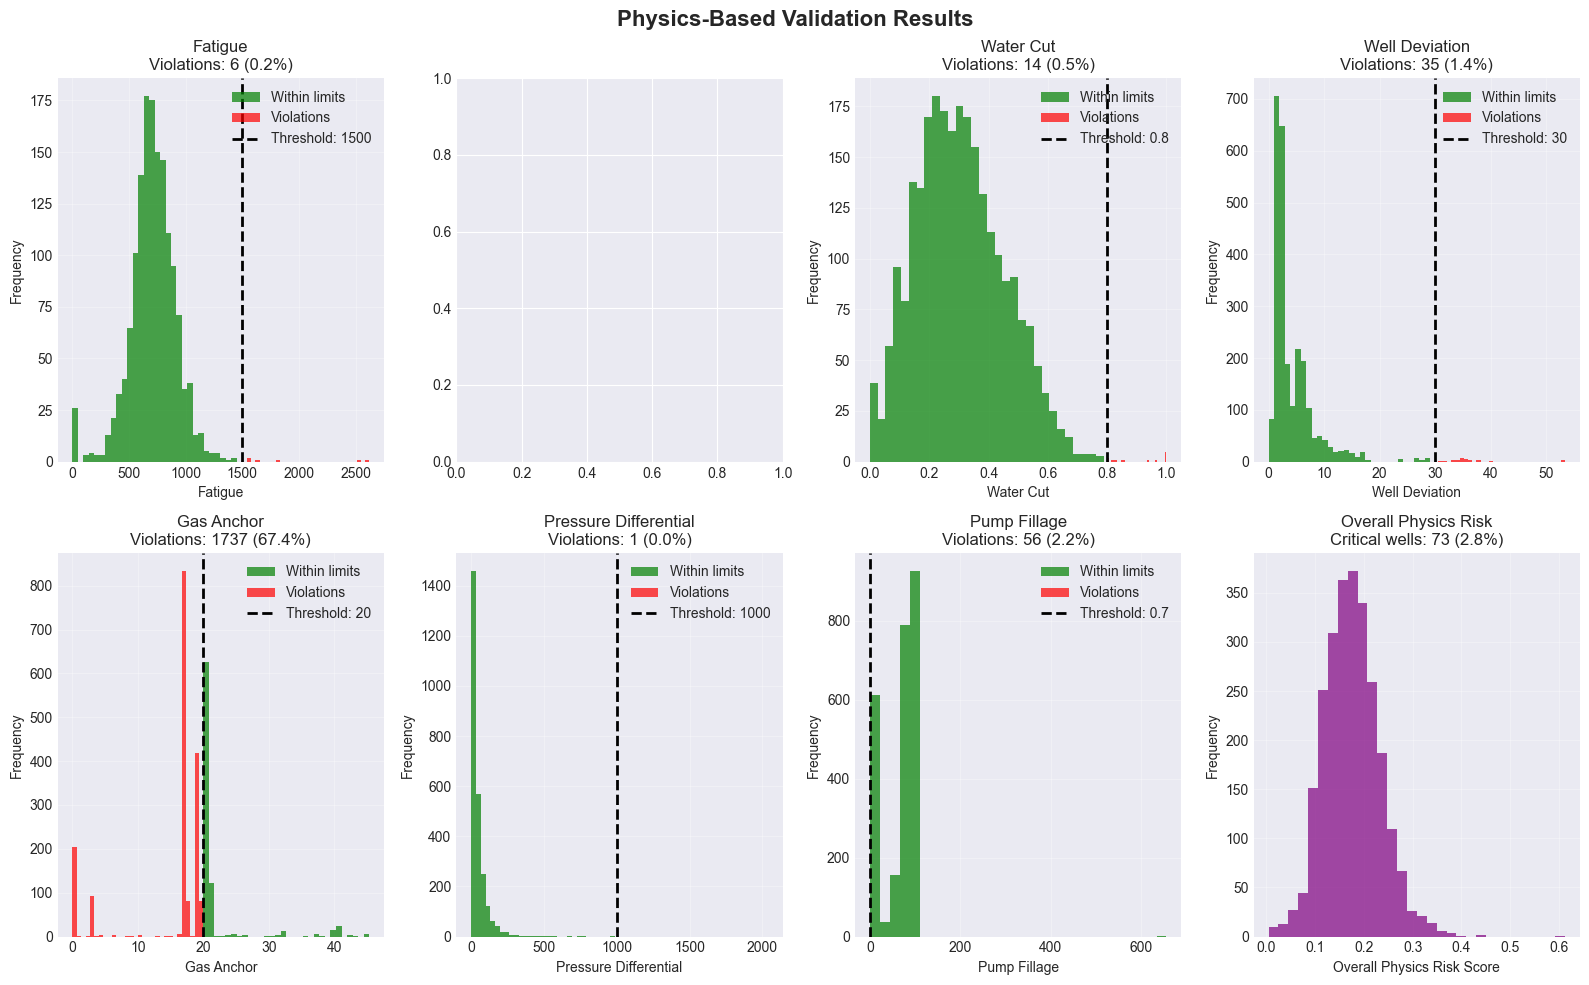


PHYSICS RISK CORRELATION WITH FAILURES
Correlation between physics risk and lifetime: -0.067


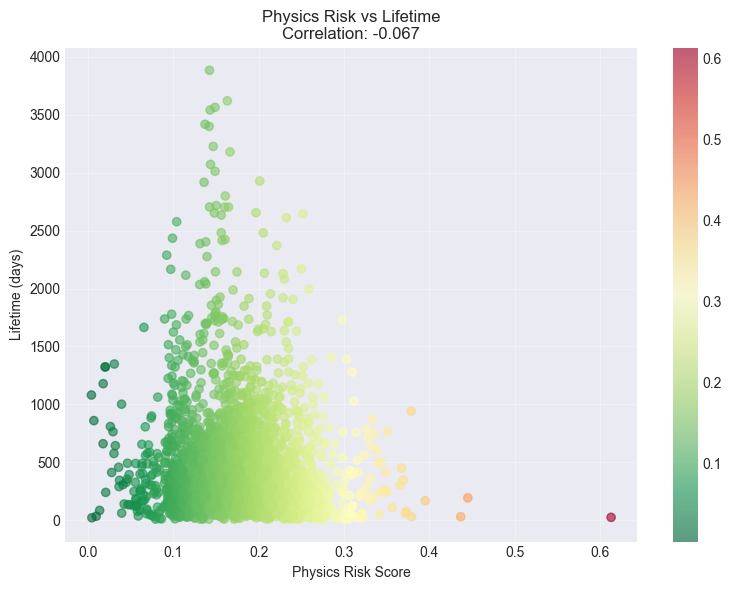


ACTIONABLE RECOMMENDATIONS BASED ON PHYSICS VALIDATION

FATIGUE:
  6 wells violate physics rule
  → Reduce stroke length or pumping speed
  → Implement pump optimization

WATER CUT:
  14 wells violate physics rule
  → Increase chemical treatment dosage
  → Consider downhole separation

WELL DEVIATION:
  35 wells violate physics rule
  → Install rod guides in deviated sections
  → Consider centralized pumps

GAS ANCHOR:
  1737 wells violate physics rule
  → Increase gas anchor length
  → Consider downhole gas separators

PRESSURE DIFFERENTIAL:
  1 wells violate physics rule
  → Optimize pump size and depth
  → Consider pressure management

PUMP FILLAGE:
  56 wells violate physics rule
  → Optimize pump intake pressure
  → Consider pump speed adjustment

PHYSICS VALIDATION COMPLETE - Results saved to physics_validation_results.pkl


In [17]:
validator = PhysicsBasedValidator()
physics_results = validator.validate_all_physics(df)

# save results for potential later use
import pickle
with open('physics_validation_results.pkl', 'wb') as f:
    pickle.dump(physics_results, f)

print("\n" + "="*80)
print("PHYSICS VALIDATION COMPLETE - Results saved to physics_validation_results.pkl")
print("="*80)